In [ ]:
!pip install lightkurve
!pip install batman-package
!pip install pandas
!pip install lmfit

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 834.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.4/270.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.6/997.6 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 58.5 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=d8d00684a8c36d81203a0e86a24849c3ff46c302576bb50d4b40e5d26f375ce2
  Stored in directory: /root/.cache/pip/wheels/71/ae/f7/5b7e1e16a133d094431428169e9a8d9f750af

In [ ]:
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

search_result = lk.search_lightcurve('TIC 307210830',exptime = 120, author = 'SPOC')
lc_collection = search_result.download_all(quality_bitmask='hardest')
lcu = lc_collection.stitch().remove_nans()

new_flux = lcu.flux.value
new_flux = np.ma.filled(new_flux, fill_value=np.nan)
new_time = lcu.time.value
new_error = lcu.flux_err.value
new_error = np.ma.filled(new_error, fill_value=np.nan)


new_array = [new_time, new_flux, new_error]
print(new_array)

np.savetxt('new_array.txt', np.column_stack((new_time, new_flux, new_error)), delimiter = ',', header = 'time,flux,flux_err', comments = '')

Mounted at /content/drive


[array([1354.10741134, 1354.1088002 , 1354.11018906, ..., 3717.91706698,
       3717.92262264, 3717.92401155]), array([1.0003744, 1.0012105, 1.0003825, ..., 1.0003841, 0.9993686,
       1.0007476], dtype=float32), array([0.00076571, 0.00076591, 0.00076605, ..., 0.00076793, 0.00076806,
       0.00076875], dtype=float32)]


In [ ]:
import lmfit as lm
import batman
import numpy as np

from lmfit import fit_report
from lmfit import minimize, Parameters

from astropy import constants as const
from astropy import units as uu

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

period = np.linspace(1, 20, 10000)
bls = lcu.to_periodogram(method='bls', period=period, frequency_factor=500);
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

new_time, new_flux, new_error = np.genfromtxt('drive/MyDrive/Colab Notebooks/new_array.txt', unpack=True, delimiter=',')
nans = np.isnan(new_time) | np.isnan(new_flux) | np.isnan(new_error)
new_time, new_flux, new_error = new_time[~nans], new_flux[~nans], new_error[~nans]

paramslm = Parameters()
paramslm.add('t', value = 3.69066906690669 , vary = True, min = 3.68, max =3.70)
paramslm.add('m', value = 0.273 , vary = False)
paramslm.add('w', value = 261, vary = False)
paramslm.add('rpl',value = 1.4 , vary = True, min =1.3 , max = 1.6 )
paramslm.add('rs', value = 0.303, vary = False )
paramslm.add('inc', value =88.11 , vary = False )
paramslm.add('ecc', value =0.115, vary = True, min = 0.09, max = 0.12)
paramslm.add('t0', value = 1356.20231 , vary = True, min = 1356.2, max = 1356.21)

#t0=vary,
def keplers_3rd_law(m,t):
    time = t*86400
    mass = m*1.989*10**30
    g = 6.67430*10**(-11)
    a = ((time**2)*g*mass)/(4*(np.pi**2))
    return a**(1/3)/(0.3*6.96*(10**8))

def rp_ratio(rpl,rs):
    return ((rpl*6378)/(rs*6.96*(10**5)))

def model_function(paramslm, new_time, error, data = None):
  vals = paramslm.valuesdict()
  t = vals['t']
  m = vals['m']
  w = vals['w']
  rpl = vals['rpl']
  rs = vals['rs']
  inc = vals['inc']
  ecc = vals['ecc']
  t0 = vals['t0']
 # frac_rp = vals['frac_rp']

  ax = keplers_3rd_law(m = m , t = t )
  rp = rp_ratio(rpl = rpl ,rs = rs )

#batman package starts here:


  params = batman.TransitParams()       #object to store transit parameters
  params.t0 = t0                        #time of inferior conjunction
  params.per = t                      #orbital period
  params.rp = rp                      #planet radius (in units of stellar radii)
  params.a = ax                       #semi-major axis (in units of stellar radii)
  params.inc = inc                     #orbital inclination (in degrees)
  params.ecc = ecc                     #eccentricity
  params.w = 261.                        #longitude of periastron (in degrees)
  params.limb_dark = "quadratic"        #limb darkening model
  params.u = [0.65,-0.11]

  model = batman.TransitModel(params, new_time)

  m_flux = model.light_curve(params)

  if data is None:
        return m_flux
  else:
        return m_flux-data



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`period` contains 212329 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


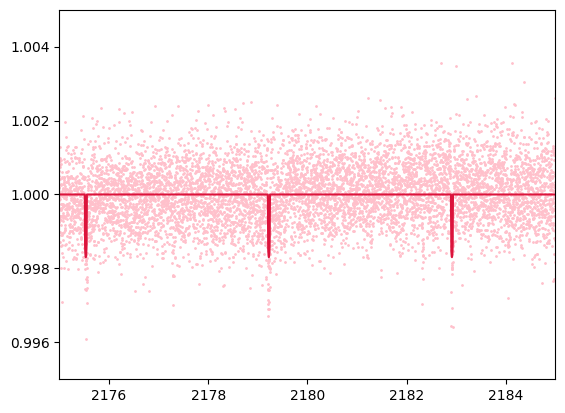

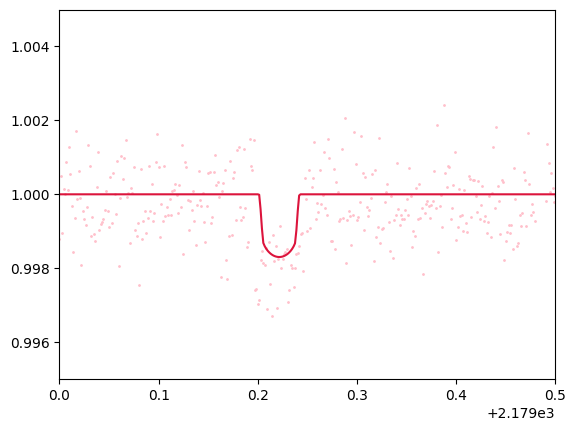

In [ ]:

m_flux = model_function(paramslm, new_time, new_error)
plt.plot(new_time, m_flux, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
plt.xlim(2175,2185)
plt.ylim(0.995,1.005)
#plt.savefig('3_Transits_of_Planet_B.png')
plt.show()

m_flux = model_function(paramslm, new_time, new_error)
plt.plot(new_time, m_flux, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
plt.xlim(2179,2179.5)
plt.ylim(0.995,1.005)
#plt.savefig('1_Transit_of_Planet_B_Zoomed_in.png')
plt.show()





In [ ]:
out = minimize(model_function, paramslm, args=(new_time, new_error), kws={'data': new_flux}, nan_policy='omit')
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3359
    # data points      = 336256
    # variables        = 4
    chi-square         = 0.22082144
    reduced chi-square = 6.5671e-07
    Akaike info crit   = -4786942.15
    Bayesian info crit = -4786899.25
[[Variables]]
    t:    3.69066741 +/- 4.9180e-07 (0.00%) (init = 3.690669)
    m:    0.273 (fixed)
    w:    261 (fixed)
    rpl:  1.47058905 +/- 0.00919335 (0.63%) (init = 1.4)
    rs:   0.303 (fixed)
    inc:  88.11 (fixed)
    ecc:  0.09000000 +/- 0.01003352 (11.15%) (init = 0.115)
    t0:   1356.20432 +/- 1.4425e-04 (0.00%) (init = 1356.202)
[[Correlations]] (unreported correlations are < 0.100)
    C(t, t0)    = -0.8306
    C(rpl, ecc) = -0.7557


**17/02/2025**

---
**Things to do:**

* Reduce errors
* see if we can phases fold the data to see the proper transit.

---
**Description of things done:**

* We managed to reduce our errors
* We found the code to phase fold, it was similar to when we phase folded at the start of the course.

---
**Papers and Resources:**

* https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag=1&constraint=disc_facility+like+%27%25TESS%25%27

* https://lmfit.github.io/lmfit-py/intro.html

---
**What to do next:**

* Mask and phase fold data.
* See how we can find mass parameter through code possibly.

/usr/local/lib/python3.11/dist-packages/astropy/utils/decorators.py:618: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


(0.994, 1.008)

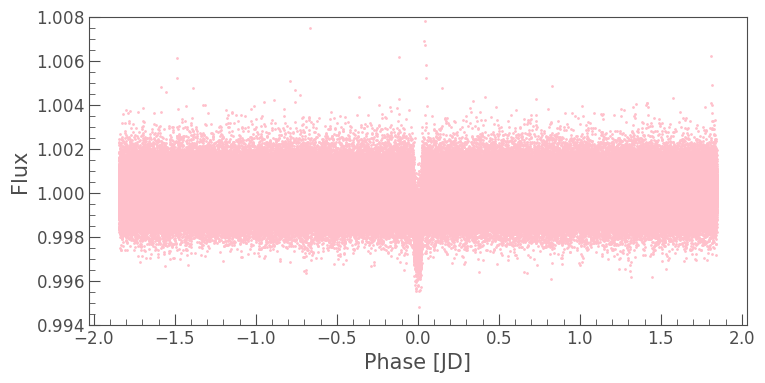

In [ ]:
planet_b_model = lk.LightCurve( time=new_time, flux = new_flux,flux_err=new_error)
planet_b_model.fold(period = out.params['t'].value, t0 = out.params['t0'].value ).scatter(c='pink', lw=1)
plt.xlim(-0.3,0.3)
plt.ylim(0.994,1.008)


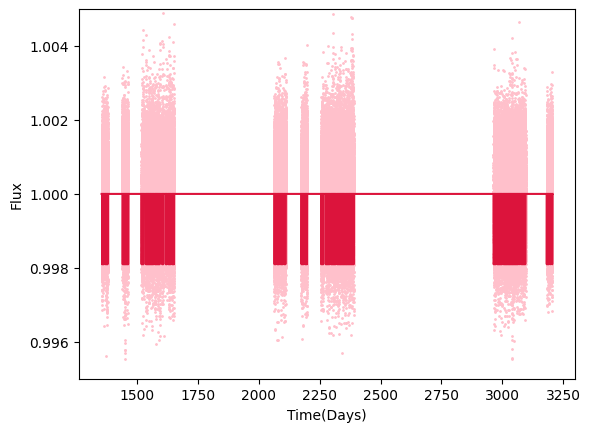

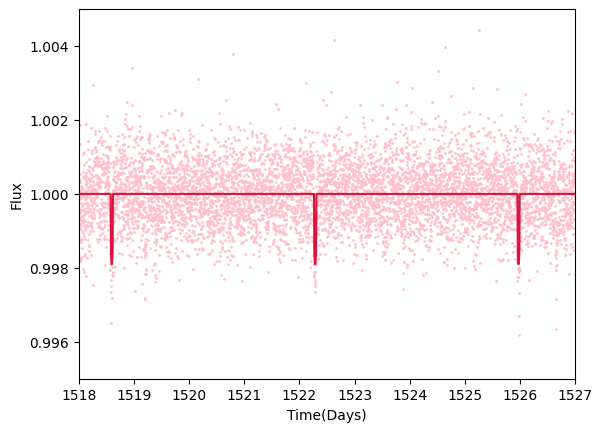

<ipython-input-23-6af22939a0c8>:22: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  bin_lcu = lcu_new.bin(binsize = 10)


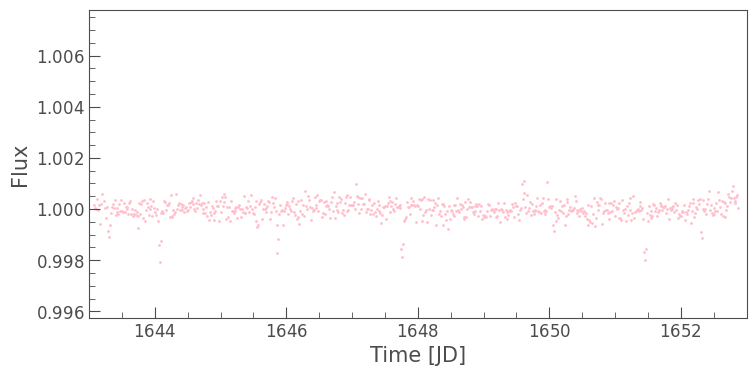

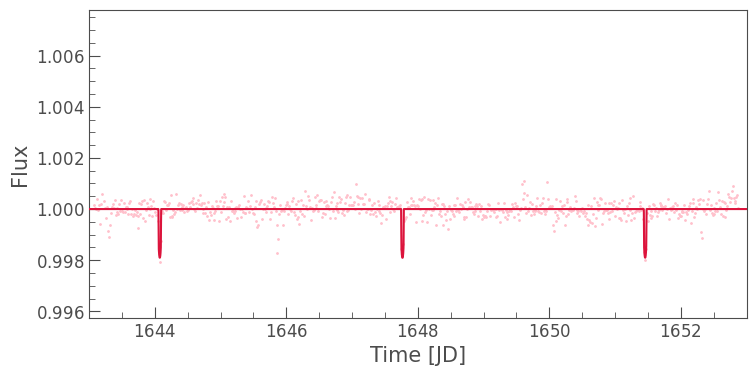

In [ ]:

min_light_curveb = model_function(out.params, new_time, new_error)

plt.plot(new_time, min_light_curveb, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
#plt.xlim(1510,1530)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.show()

plt.plot(new_time, min_light_curveb, color= 'crimson')
plt.scatter(new_time, new_flux,color = 'pink', marker = '.', s = 4)
plt.xlim(1518,1527)
plt.ylim(0.995,1.005)
plt.xlabel('Time(Days)')
plt.ylabel('Flux')
plt.show()



lcu_new = lk.LightCurve( time=new_time, flux = new_flux,flux_err=new_error)
bin_lcu = lcu_new.bin(binsize = 10)

bin_lcu.scatter(color = 'pink')
plt.xlim(1643,1653)
plt.show()

bin_lcu.scatter(color = 'pink')
plt.plot(new_time,min_light_curveb , zorder = 10, color = 'crimson')
plt.xlim(1643,1653)
plt.show()

<ipython-input-14-b7d0a4fe65dd>:13: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  bin_lcu = lcu_new_masked.bin(binsize = 10)


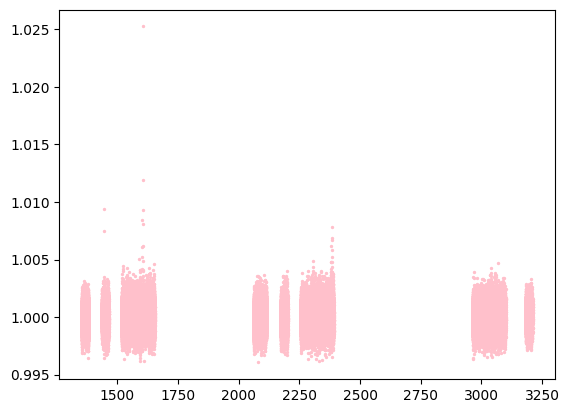

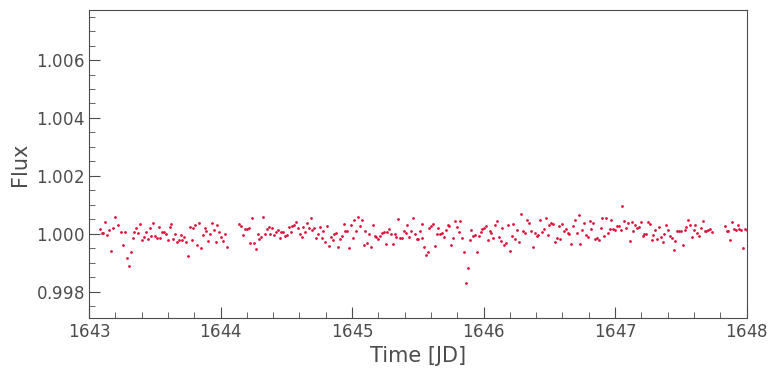

In [ ]:
sorted = np.argsort(new_time)
new_time = new_time[sorted]
new_flux = new_flux[sorted]
new_error = new_error[sorted]

masked_fluxb = new_flux / min_light_curveb
masked_timeb = new_time / min_light_curveb
masked_errorb = new_error / min_light_curveb



lcu_new_masked = lk.LightCurve( time=masked_timeb, flux = masked_fluxb,flux_err=masked_errorb)
bin_lcu = lcu_new_masked.bin(binsize = 10)
plt.scatter(masked_timeb, masked_fluxb, zorder = 10, color = 'pink', s = 2)
bin_lcu.scatter(color = 'crimson')
plt.xlim(1643,1648)
plt.show()



**20/02/2025**


---

**Things to do:**


*  Phase fold data and print result of transit.
*  Bin the data and show the model function on top of binned data.
*  Attempt to mask the data on top of that.


---
**Description of things done:**


*   We managed to fulfill our aims for this session including the masking.
*   We mrealised that our limb darkening values aren't on the exofop archive so we are going to find that for our Planet B then we will adjust our limb darkening values.



---
**Issues we ran into:**


*   Errors on our parameters are still too high or we don't have a good initial value of our parameters such as eccentricity.
*   We need to check that our mask actually worked just because it looks like there aren't actually a lot of data points adfter the masking.



---
**Papers and Resources:**


*   https://exoplanetarchive.ipac.caltech.edu/index.html
*   https://lmfit.github.io/lmfit-py/intro.html


---
**What to do next:**
  
*   Need to check masking is correct
*   Need to find mass parameter and also make sure all limb darkening values are correct and reduce the error margins.





